In [1]:
import os
os.getcwd()

'/Users/aran/Documents/GitHub/BiPAnalysisCodeShare/forage_detect'

In [2]:
# DVLRead

from pathlib import Path
# bring in functions from main_func
from main_func import *
from math import pi
from scipy.signal import find_peaks
from scipy import stats

import pandas as pd
import re

# parent folder for all DVL data
# dvlFolders = "E:/My Drive/PhD/Data/2018Shearwater/DVL"
dvlFolders = "/Users/aran/Documents/DVL"

In [21]:
# acc and vid starttimes
st17008 = [pd.to_datetime('31/08/2018 06:00:00', format = "%d/%m/%Y %H:%M:%S"),
           pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18012 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 10:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18014 = [pd.to_datetime('31/08/2018 06:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18017 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 11:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18018 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
starttimes = [st17008,st18012,st18014,st18017,st18018]

tagnames = ['17008','18012','18014','18017','18018']

# dictionaries storing start times (acceleration [0], video [1])
tagInfo = dict(zip(tagnames,starttimes))

# initialise dictionary
tagData = {}

# read in the video behaviour records
behavClass = pd.read_csv('/Users/aran/Library/CloudStorage/GoogleDrive-aran.garrod@googlemail.com/My Drive/Data/DVL/DiveBehavClass.csv', sep = ',', usecols = [0,1,2,4], dtype = {'Tag' : str})

# replace 'Dive' behaviour with 's' (surface) or 'd' (dive)
behavClass.loc[behavClass['Behaviour'] == 'Dive','Behaviour'] = behavClass.loc[behavClass.Behaviour == 'Dive','ForageBeh']
# remove superfluous column
behavClass.drop('ForageBeh',axis = 1, inplace = True)

# set time to datetime
behavClass.Time = pd.to_datetime('31/08/2018 ' + behavClass.Time, format = '%d/%m/%Y %H.%M.%S.%f')


# path=Path(dvlFolders+"/18012/acc-video-2018-18012.txt")

for path in Path(dvlFolders).rglob('*acc*.txt'):
    
    print(f"Reading in acceleration data")
    # read in acceleration data
    dat = pd.read_table(path.__str__(), skiprows = 7, sep = ',', usecols = [0,1,2])

    # remove whitespace from headers
    dat.rename(columns=lambda x: x.strip(), inplace = True)

    # add time series
    dat['DT'] = pd.date_range(tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][0], periods = len(dat), freq = '50ms')

    # select data within video range
    dat = dat[(dat.DT >= tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][1]) & (dat.DT < tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][1] + pd.Timedelta(hours=2))]

    # calculate pitch (clip array to min max of -1 1, assumes acceleration measured in g)
    print(f"Calculating pitch")
    dat = pd.concat([dat.reset_index(), accFeatures(dat[['X','Y','Z']],['Y','Z','X'],1.5,3,20)], axis = 1)
    tagname=re.search(r"(\d{5}?).txt",path.name).group(1)
    print(f"read in tag {tagname}")

    # generate spectrogram and summed spectral energy difference
    print(f"Generating spectrogram and spectral energy sums")
    f,s,Sxx = hammingSpect(dat.Z, fs = 20)
    rollSum = rollingSpecSum(Sxx, f, 3, 5, fs = 20)
    print(f"Performing roll sum")

    # extract behaviours for the specific tag
    bc = behavClass[behavClass.Tag == re.search(r"(\d{5}?).txt",path.name).group(1)]
    print(f"Popping behaviour classes")

    # remove minute containing AT behaviour
    print(f"Removing erroneous behaviour periods")
    if bc.Behaviour.eq('AT').any():
        print(f"AT present")
        behAT = np.any([(dat.DT >= (x - pd.Timedelta(30,'sec'))) & (dat.DT <= (x + pd.Timedelta(30,'sec'))) for x in bc.Time[bc.index[bc.Behaviour == 'AT']].round("s").values], axis = 0)

        rollSum[behAT[(2*20):-(2*20)+1]] = min(rollSum)
    
    print(f"Calculating {10} flight periods")

    flight_inds = maxWithGap(rollSum,20,numPoints=10)

    tagData[re.search(r"(\d{5}?).txt",path.name).group(1)] = {'acc' : dat, 'beh' : bc, 'fl_inds': flight_inds}

# returns dictionary for each tag, each contain two keys, 'acc' for acceleration data, 'beh' for video-derived behaviours. Data should be aligned.

# maxWithGap(rollSum,20,numPoints=10)



Reading in acceleration data
Calculating pitch
read in tag 18017
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating pitch
read in tag 18018
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
Calculating 10 flight periods
Reading in acceleration data
Calculating pitch
read in tag 18014
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating pitch
read in tag 17008
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating pitch
read in tag 1801

## Identifying flapping

We use the doresoventral acceleration signal to identify flapping vs gliding/other behaviours. This signal, shown below, contains large changes in magnitude when the bird performs up or down strokes, with smaller changes during period of gliding. We will use this characteristic to isolate flapping signals.

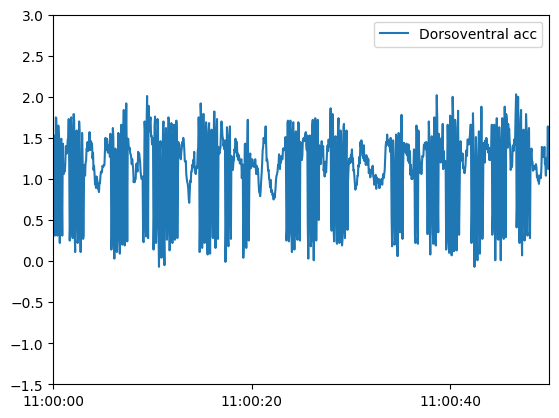

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

xformatter = mdates.DateFormatter('%H:%M:%S')
plt.plot(tagData['18017']['acc'].DT,tagData['18017']['acc'].Z,label='Dorsoventral acc')
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

### Isolating signal extrema

Simply finding the peaks and troughs is trivial, shown below, but now flapping vs gliding signals must be separated.

In [10]:
sig = tagData['18017']['acc'].Z
peaks,_ = find_peaks(sig)
troughs,_ = find_peaks(-sig)

if peaks[0] > troughs[0]:
    peaks.pop(0)
if peaks[-1] > troughs[-1]:
    peaks.pop(-1)

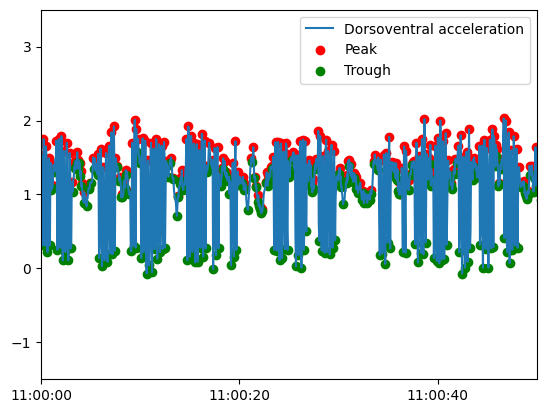

In [11]:
xformatter = mdates.DateFormatter('%H:%M:%S')
plt.plot(tagData['18017']['acc'].DT,tagData['18017']['acc'].Z,label='Dorsoventral acceleration')
plt.scatter(tagData['18017']['acc'].DT[peaks],sig[peaks],c='r',label='Peak')
plt.scatter(tagData['18017']['acc'].DT[troughs],sig[troughs],c='g',label='Trough')
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

### Using densities

If we take magnitude differences across peaks and troughs, we can generated a density estimate of this magnitude. We expect two peaks,representing the typical magnitude change during flapping (higher) vs gliding (lower). Assuming these represent typical magnitude changes between the two behaviours, we take the trough found between these two peaks, the inter-peak trough, as the treshold for a dorsoventral acceleration magnitude change that indicates a flap vs a glide:

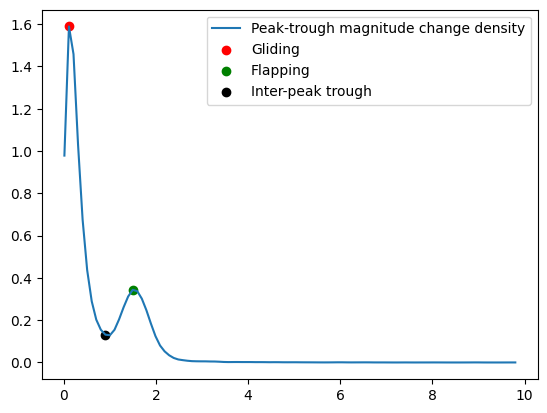

In [12]:
data = sig[peaks].values - sig[troughs].values
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

ppeaks,_ = find_peaks(p)

# take first two peaks and find the trough inbetween
pks,_ = find_peaks(-p[ppeaks[0]:ppeaks[1]])

# retain only sufficiently large z displacements
flapInds = (sig[peaks].values - sig[troughs].values) > x[pks]

plt.plot(x,p,label='Peak-trough magnitude change density')
plt.scatter(x[ppeaks[0]],p[ppeaks[0]],c='r',label='Gliding')
plt.scatter(x[ppeaks[1]],p[ppeaks[1]],c='g',label='Flapping')
plt.scatter(x[pks],p[pks],c='k',label='Inter-peak trough')
plt.legend()

Sticking all this together, we now only keep peaks and troughs where the magnitude change exceeds this inter-peak trough, and this gives us a decent indication of when the bird was flapping, the number of times, how often etc.

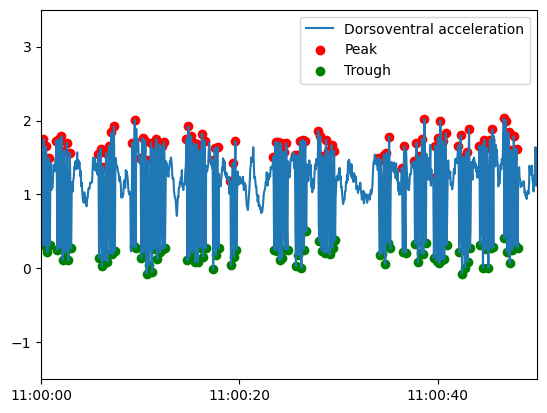

In [13]:
xformatter = mdates.DateFormatter('%H:%M:%S')
plt.plot(tagData['18017']['acc'].DT,tagData['18017']['acc'].Z,label='Dorsoventral acceleration')
plt.scatter(tagData['18017']['acc'].DT[peaks[flapInds]],sig[peaks[flapInds]],c='r',label='Peak')
plt.scatter(tagData['18017']['acc'].DT[troughs[flapInds]],sig[troughs[flapInds]],c='g',label='Trough')
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

In [20]:
flapInds
[(y - x) for (x, y) in zip(peaks[flapInds][:-1], peaks[flapInds][1:])]


[4,
 5,
 6,
 15,
 5,
 5,
 6,
 5,
 6,
 57,
 5,
 5,
 6,
 6,
 5,
 5,
 37,
 5,
 11,
 5,
 5,
 6,
 6,
 5,
 5,
 6,
 5,
 5,
 45,
 4,
 5,
 6,
 6,
 5,
 5,
 6,
 16,
 4,
 6,
 25,
 6,
 5,
 76,
 5,
 5,
 6,
 5,
 5,
 18,
 5,
 6,
 5,
 5,
 26,
 4,
 6,
 6,
 4,
 7,
 5,
 89,
 5,
 6,
 5,
 6,
 25,
 5,
 20,
 5,
 6,
 5,
 5,
 17,
 5,
 5,
 5,
 5,
 6,
 25,
 5,
 6,
 6,
 5,
 21,
 5,
 5,
 5,
 6,
 5,
 23,
 4,
 6,
 5,
 5,
 6,
 76,
 4,
 6,
 6,
 21,
 5,
 5,
 5,
 6,
 4,
 6,
 6,
 5,
 108,
 5,
 5,
 5,
 5,
 18,
 4,
 5,
 6,
 5,
 6,
 6,
 35,
 35,
 5,
 6,
 17,
 5,
 5,
 6,
 5,
 6,
 19,
 5,
 6,
 5,
 38,
 5,
 5,
 6,
 6,
 5,
 5,
 18,
 4,
 5,
 6,
 4,
 5,
 36,
 5,
 5,
 5,
 5,
 7,
 58,
 5,
 6,
 4,
 5,
 4,
 5,
 18,
 5,
 5,
 5,
 5,
 6,
 5,
 6,
 4,
 6,
 4,
 5,
 5,
 6,
 5,
 5,
 65,
 5,
 6,
 6,
 6,
 34,
 4,
 6,
 5,
 6,
 35,
 5,
 6,
 6,
 26,
 5,
 6,
 5,
 5,
 25,
 4,
 6,
 5,
 5,
 5,
 7,
 5,
 65,
 5,
 5,
 14,
 4,
 6,
 5,
 6,
 6,
 6,
 5,
 5,
 5,
 41,
 5,
 5,
 4,
 5,
 5,
 11,
 4,
 5,
 5,
 5,
 6,
 88,
 7,
 6,
 11,
 6,
 5,
 53,
 4,
 6,
 5,
 5,
 